### Parse all images in custom folder, saves their color and path into the data array

In [12]:
import matplotlib.pyplot as plt
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.feature_extraction import image
from skimage import io
from sklearn.manifold import TSNE

data = []
folder = './assets/cover/'

for filename in os.listdir(folder):
    image = cv2.imread(os.path.join(folder,filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        image = image.flatten()
        data.append([image, folder + filename])


In [ ]:
features, images  = zip(*data)

### Training part

instantiate a PCA object, which we will then fit our data to, choosing to keep the top 300 principal components. This may take a few minutes.

In [13]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

image: [ 1.27760669e+03  9.42663971e+02  3.52553652e+02  4.01342161e+02
  1.08175775e+02  2.35665803e+02  9.76694301e+01 -7.50101498e+00
 -4.64524146e+02  1.26867448e+02 -1.06953015e+02  8.84510371e+01
 -7.25424448e+01  7.85672418e+01 -5.31902396e+01 -1.33931896e+02
  6.45071997e+00 -9.75872314e+01  1.31491698e+02  3.12597431e+02
 -4.50040052e+01 -1.58080637e+02  1.62570458e+01 -1.56631244e+01
  2.77688945e+00  9.87749543e-01  3.37110230e+00 -1.78524242e+02
  1.35594663e+02 -8.99694391e+01  7.52008788e+01  4.65229218e+00
 -8.89574190e+01  5.73155630e+01 -1.86176417e+02 -1.41877438e+02
 -2.85656755e+01  1.12199099e+02 -1.89526178e+01 -2.44275982e+01
 -7.82678777e+00  4.23067072e+01 -6.24702200e+01 -1.59281478e+01
  7.07819312e+01 -3.98320224e+01  4.62266747e+01 -1.31207673e+01
  2.79451632e+01 -6.53448718e+01  5.39914228e+01 -4.10057934e+01
  1.65648044e+02 -1.27220615e+02  5.00394330e+01 -4.24189074e+01
  2.63633559e+01 -8.55094625e+00  5.28204861e+00  3.44974606e+01
 -1.83370781e+00 -

In [14]:
num_images_to_plot = 15000

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [15]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14985 samples in 0.169s...
[t-SNE] Computed neighbors for 14985 samples in 73.609s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14985
[t-SNE] Computed conditional probabilities for sample 2000 / 14985
[t-SNE] Computed conditional probabilities for sample 3000 / 14985
[t-SNE] Computed conditional probabilities for sample 4000 / 14985
[t-SNE] Computed conditional probabilities for sample 5000 / 14985
[t-SNE] Computed conditional probabilities for sample 6000 / 14985
[t-SNE] Computed conditional probabilities for sample 7000 / 14985
[t-SNE] Computed conditional probabilities for sample 8000 / 14985
[t-SNE] Computed conditional probabilities for sample 9000 / 14985
[t-SNE] Computed conditional probabilities for sample 10000 / 14985
[t-SNE] Computed conditional probabilities for sample 11000 / 14985
[t-SNE] Computed conditional probabilities for sample 12000 / 14985
[t-SNE] Computed conditional probabilities for sa

Internally, t-SNE uses an iterative approach, making small (or sometimes large) adjustments to the points. By default, t-SNE will go a maximum of 1000 iterations, but in practice, it often terminates early because it has found a locally optimal (good enough) embedding.

The variable tsne contains an array of unnormalized 2d points, corresponding to the embedding. In the next cell, we normalize the embedding so that lies entirely in the range (0,1).

In [16]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

### Plots the clusters

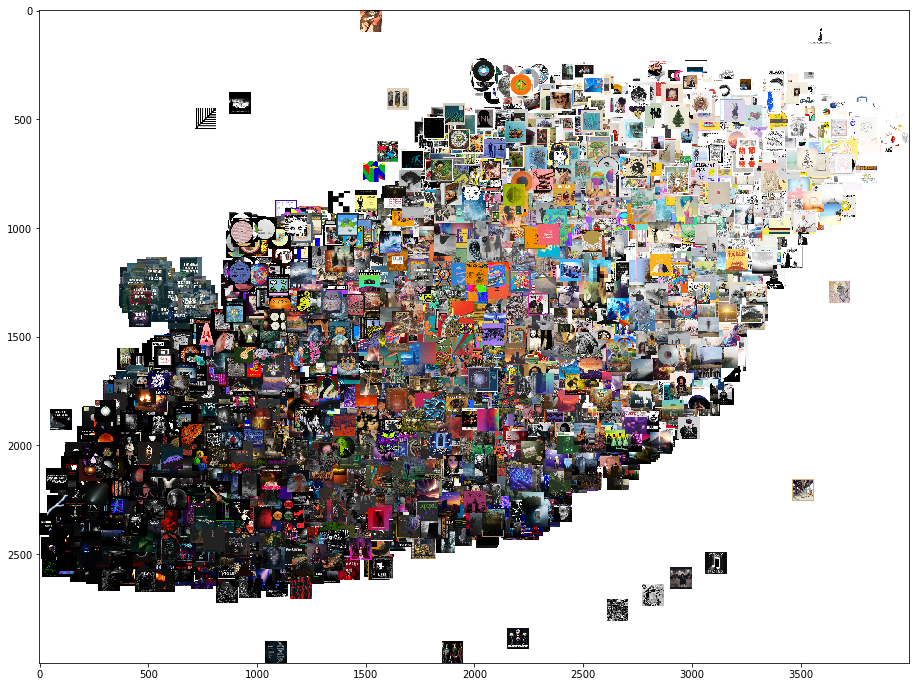

In [17]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

### Save a json and a png of the cluster

In [7]:
import os
import json

full_image.save("test_tSNE.png")

tsne_path = "test_tSNE.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)


### Paste into grid

In [18]:
import rasterfairy
nx = 70
ny = 72

grid_assignment = rasterfairy.transformPointCloud2D(tsne)

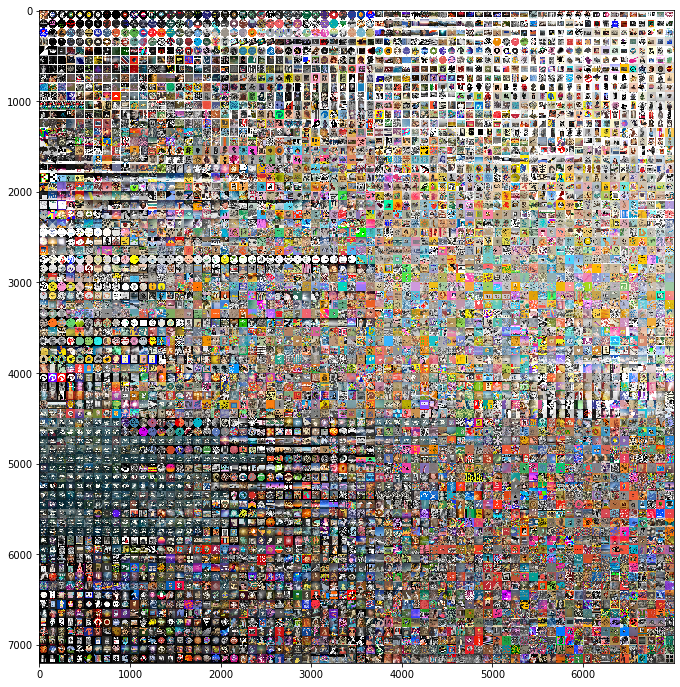

In [19]:
tile_width = 100
tile_height = 100

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGBA', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

In [20]:
background = Image.new("RGB", grid_image.size, (255, 255, 255))
background.paste(grid_image, mask=grid_image.split()[3]) # 3 is the alpha channel

background.save('grid-tSNE.jpg', 'JPEG', quality=100)